# Classification Mini-Project: Ahan Trivedi

### We all know how confusing undergraduate admissions can be, so I wanted to see if it is feasible to classify who gets into the University of Pennsylvania's Wharton MBA program based on quantifiable parts of an applicants application.

Lets's first load the dataset as a Pandas Dataframe to see what parameters we have on each applicant. The data that I am using for this analysis comes from https://www.kaggle.com/datasets/taweilo/mba-admission-dataset. It was taken from the University of Pennsylvania's published admission statistics for the MBA class of 2025, and uploaded to Kaggle in a CSV format by Ta-Wei Lo.

In [3]:
import pandas as pd

file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv'
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'

print(df.head(50))

    application_id  gender  international   gpa       major      race   gmat  \
0                1  Female          False  3.30    Business     Asian  620.0   
1                2    Male          False  3.28  Humanities     Black  680.0   
2                3  Female           True  3.30    Business   Unknown  710.0   
3                4    Male          False  3.47        STEM     Black  690.0   
4                5    Male          False  3.35        STEM  Hispanic  590.0   
5                6    Male          False  3.18    Business     White  610.0   
6                7  Female          False  2.93        STEM     Other  590.0   
7                8    Male           True  3.02    Business   Unknown  630.0   
8                9    Male          False  3.24    Business     White  590.0   
9               10    Male          False  3.27  Humanities     Asian  690.0   
10              11    Male          False  3.05  Humanities     White  580.0   
11              12    Male           Tru

The dataset includes various features like application ID, gender, international status, GPA, major, race, GMAT score, years of work experience, and industry, along with the admission status (Admit, Waitlist, or Deny). I'm going to use this dataset to develop multiple iterations of a multilayer perceptron neural network based machine learning model to try predict admission outcomes based on quantifiable statistics (our features of the model) of an applicants application. Understanding trends in MBA admissions can help future applicants focus on improving the correct parts of their application, and give themselves a better shot at getting into their dream buisness programs. To provide value, the algorithm would need to have recall, accuracy and precision rates above 90%. It should be able to confidently tell us whether someone is going to get in or rejected, so future students aren't left in the dark about what is going to happen to them. Having just one metric high is not good enough to confidently say our model can give future applicants a well rounded prediction, since it could only be identifying if students get rejected correctly, or vise versa. This approach is inherently trying to objectify a very subjective process, so there are a lot of risks with trusting this model without caution. If blind trust is placed in this approach, future applicants could incorrectly gauge their likelihood of admission, and not understand that there are nuances to the MBA admissions process at Wharton.

Let's run our first iteration of our Multilayer Perceptron (MLP) on our dataset. We are going to be using pytorch and sckikit-learn as our main ML libraries which will do a lot of the work 'under the hood'. The key attributes of this iteration is that the lambda value is 0.0001, there are 4 layers to the model, and we are running this on 6000 epochs.

In [11]:
# ----------------------------------------------MODEL ITERATION 1-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        NEED A DOCSTRING
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 256) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(256, 128) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(128, 64)  # Third layer with 64 input neurons and 2 output layers
        self.fc4 = nn.Linear(64, 2) # Output layer with 2 classes
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        NEED A DOCSTRING
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the third layer
        x = self.dropout(x) # Initiate a droupout
        x = self.fc4(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 6000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

In our model, we seperated our data into a training and a test set, and then further seperated our training data into a training and validation set. The reason we did this was to prevent the 'model tuner' (me in this case) from manually tweaking parameters based on the test loss, which takes away the point that the test data shouldn't influence the model's parameters. By having a validation set, we are able to completely adjust the model parameters based on the training and validation data alone, so can keep the test data for when we actually want to test the model.

Let's see the losses for our training and validation set to judge whether or not this model is 'optimized' and ready for test data to be run on it.

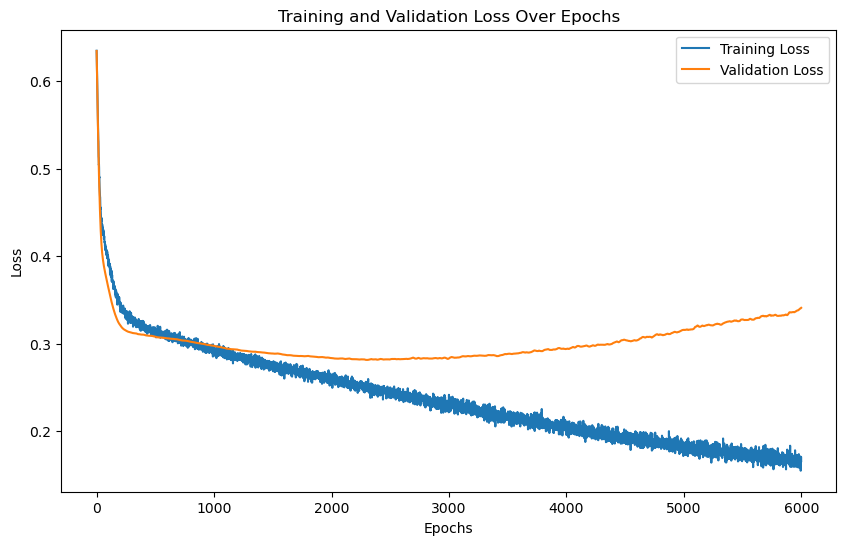

In [12]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

TALK ABOUT OVERFITTING

Let's run our second iteration of the model. The implementation will stay virtually the same as last time, except we will change some parameters to prevent overfitting the model to the training data. The key attributes of this iteration is that the lambda value is 0.0001, there are 3 layers to the model, and we are running this on 6000 epochs.

In [13]:
# ----------------------------------------------MODEL ITERATION 2-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        NEED A DOCSTRING
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 128) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(128, 64) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(64, 2)  # Output layer
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        NEED A DOCSTRING
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 6000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

Once again, let's see the losses for our training and validation set to judge whether or not this model is 'optimized' and ready for test data to be run on it. Hopefully we made an improvement this time!

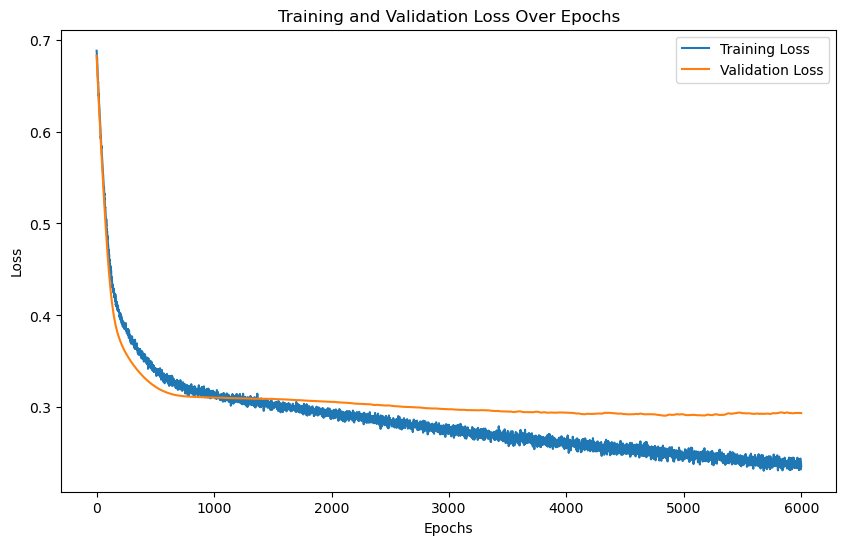

In [14]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

TALK ABOUT OVERFITTING

Let's run a third and final iteration. As with the prior iterations, the implementation will stay virtually the same as last time, except we will change some parameters to prevent overfitting the model to the training data. The key attributes of this iteration is that the lambda value is 0.0001, there are 3 layers to the model, and we are running this on 1000 epochs. Hopefully the third time is the charm!

In [9]:
# ----------------------------------------------MODEL ITERATION 3-----------------------------------------------------------

# Step 0: Import necessary libraries and modules

import pandas as pd # Import pandas library to load kaggle data into a pandas dataframe
import torch # Import pytorch for building and training the model
import torch.nn as nn # Import neural network module from PyTorch
import torch.optim as optimizer # Import optimization algorithms from Pytorch for backward pass
from sklearn.model_selection import train_test_split # Import test-train split feature
from sklearn.preprocessing import StandardScaler # Import feature scaling feature
from sklearn.metrics import accuracy_score, precision_score, recall_score # Import metrics
import matplotlib.pyplot as plt # Import matplotlib for graphing
import numpy as np

# Step 1: Load and Preprocess the data

# Load the dataset
file_path = '/mnt/c/Users/atrivedi/Downloads/archive/MBA.csv' # Local file path to dataset
df = pd.read_csv(file_path) # Read csv into pandas dataframe
df['admission'] = df['admission'].fillna(0)  # Assume NaN means 'Rejected' and fill with 0
df['race'] = df['race'].fillna('Unknown')  # Fill missing race with 'Unknown'


# Preprocess the dataset
df = pd.get_dummies(df, columns=['gender', 'international','race','major', 'work_industry'], drop_first=True) # Convert categorical (strings) variables into dummy (binary) variables so the neural net can work with it, not admission though
df['admission'] = df['admission'].apply(lambda x: 1 if x == 'Admit' else 0) # Convert 'Admit' to 1 and others to 0 for binary classification
X = df.drop('admission', axis=1) # Drop the admission column, so the features and the outputs aren't paired together
y = df['admission'] # Target variable
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split the data into training and test sets --> 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # Further split the training data into train and validation (to prevent manually tuning parameters to the output of the test data)
scaler = StandardScaler() # Create an instance of the StandardScaler class to scale our values
X_train = scaler.fit_transform(X_train) # Calculates the mean and standard deviation for each feature in the training dataset and then scales the training data based on these statistics.
X_val = scaler.transform(X_val) # Learns the scaling parameters from the training data and scales validation data
X_test = scaler.transform(X_test) # Learns the scaling parameters from the training data and scales test data
X_train_tensor = torch.FloatTensor(X_train)  # Convert training features to PyTorch tensor
X_val_tensor = torch.FloatTensor(X_val) # Convert validation features to PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test)  # Convert test features to PyTorch tensor
y_train_tensor = torch.LongTensor(y_train.values)  # Convert training labels to LongTensor (for classification)
y_val_tensor = torch.LongTensor(y_val.values) # Convert validation labels to LongTensor
y_test_tensor = torch.LongTensor(y_test.values)  # Convert test labels to LongTensor

# Define MLP Model
class MLP(nn.Module): # Define a class for the MLP model, inheriting from the nn.Module framework
    def __init__(self, input_size): # Initialize the model with the input size
        """
        NEED A DOCSTRING
        """
        super(MLP, self).__init__() # Allows MLP class to initialize any properties defined in nn.Module
        self.fc1 = nn.Linear(input_size, 128) # First layer with input size (based on columns of the df) and 256 neurons (output)
        self.fc2 = nn.Linear(128, 64) # Second layer with 256 input neurons and 128 output neurons
        self.fc3 = nn.Linear(64, 2)  # Output layer
        self.relu = nn.ReLU() # Initializes the ReLU activaton function to introduce non-linearity into the model
        self.dropout = nn.Dropout(p=0.5) # Add dropout
    def forward(self, x): # Define the forward pass 
        """
        NEED A DOCSTRING
        """
        x = self.relu(self.fc1(x)) # Apply the first layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.relu(self.fc2(x)) # Apply the second layer and ReLU activation
        x = self.dropout(x) # Initiate a dropout
        x = self.fc3(x) # Pass through the output layer
        return x # Return the final output

# Step 3: Instantiate the model

input_size = X_train.shape[1] # Get the number of input features (columns of the df)
model = MLP(input_size) # Create an instance of the MLP model

# Step 4: Set up the loss function and optimizer

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optimizer.Adam(model.parameters(), lr=0.0001)  # Set up the Adam optimizer with a learning rate of 0.001 (this is useful for the backward pass)

# Step 5: Train the model
num_epochs = 1000 # Determine how many epochs of the model we want
train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses
test_losses = [] # List to store test losses
for epoch in range(num_epochs): # Loop over each epoch
    model.train() # set the model to training mode
    optimizer.zero_grad()  # Clear gradients from the previous step
    outputs = model(X_train_tensor)  # Perform a forward pass to get model predictions
    loss = criterion(outputs, y_train_tensor)  # Compute the loss using the predictions and true labels
    loss.backward()  # Backpropagate the loss to compute gradients
    optimizer.step()  # Update model parameters based on computed gradients

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on validation loss and test loss 
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        val_outputs = model(X_val_tensor)  # Forward pass on validation data
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss
        test_outputs = model(X_test_tensor)  # Forward pass on validation data
        test_loss = criterion(test_outputs, y_test_tensor)  # Compute validation loss
        test_losses.append(test_loss.item())  # Store validation loss

Will our training and validation losses be 'optimized' now. Let's see!

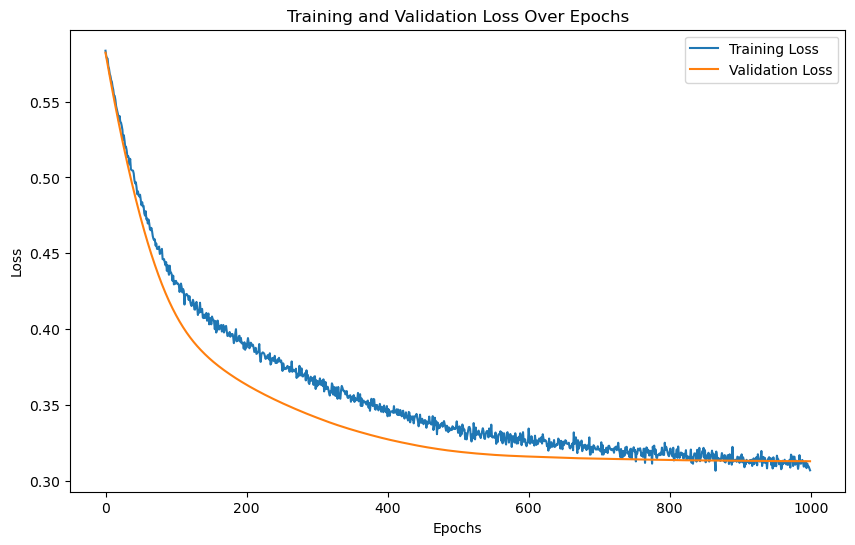

In [10]:
# Step 6: Plot the losses for Training and Validation data
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

TALK ABOUT HOW WE ARE GOING TO USE THIS ITERATION

GET METRICS USING LAST MODEL ON TESTING DATA TO SEE HOW WELL IT PERFORMS

Accuracy: 0.8588
Precision: 0.6667
Recall: 0.2143


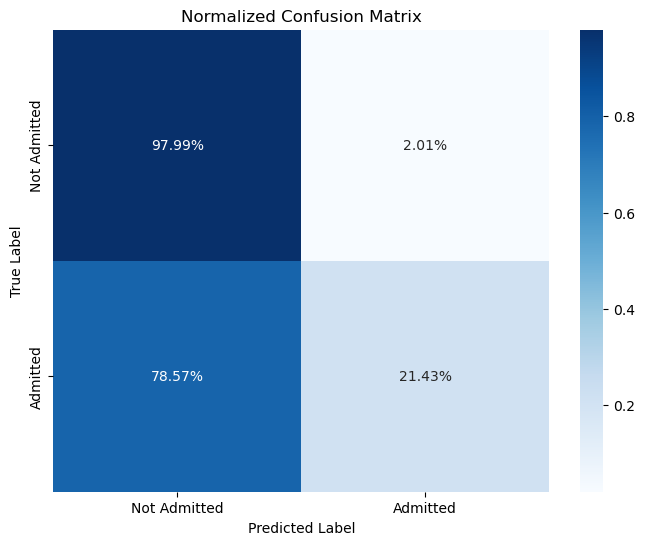

In [15]:
# Import necessary libraries for metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns 
import numpy as np

# After training your model, generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Forward pass on test data
    _, y_pred = torch.max(test_outputs, 1)  # Get the predicted class labels

# Convert tensors to numpy arrays for scikit-learn
y_test_np = y_test_tensor.numpy()  # True labels
y_pred_np = y_pred.numpy()  # Predicted labels

# Step 1: Create the confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Convert to percentages

# Step 2: Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Step 3: Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Not Admitted', 'Admitted'], 
            yticklabels=['Not Admitted', 'Admitted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()



TALK ABOUT WHY IT PERFORMS SO POORLY (UNBALANCED DATA)

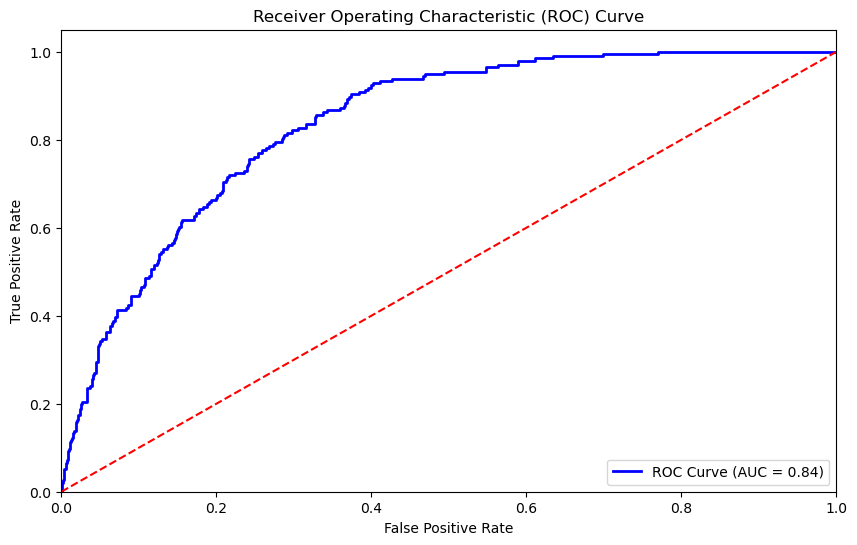

In [20]:
from sklearn.metrics import roc_curve, auc
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Forward pass on test data
    probabilities = nn.Softmax(dim=1)(test_outputs)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, probabilities)  # y_test should be the actual labels
roc_auc = auc(fpr, tpr)  # Calculate the AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Therefore, an AUC of 0.81 means that the model is able to correctly distinguish between positive and negative classes 81% of the time based on the area under the ROC curve. A value of 0.81 indicates that the model has a relatively strong ability to identify true positive cases while minimizing false positives.

